In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn.functional as F
import torch.utils.data as Data
import torch.nn as nn
from torchvision import transforms, datasets

In [3]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import datasets

In [4]:
from tqdm import tqdm

In [5]:
import warnings
warnings.simplefilter("ignore")

In [6]:
datum = sklearn.datasets.fetch_california_housing()

In [7]:
concat_california = np.concatenate((datum.data, np.reshape(datum.target,
                                   (datum.target.shape[0],1))), axis = 1)

In [8]:
calif_df = pd.DataFrame(concat_california,
                        columns = datum.feature_names + ['price'])

In [9]:
calif_df.head(10)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


In [10]:
X = datum.data
y = datum.target
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                   test_size = 0.25, random_state=13)

In [11]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [12]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).view(-1, 1).float()

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(datasets, batch_size=77,
                                           shuffle=True)

In [13]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        if self.activation=="relu":
            return F.relu(x)
        if self.activation=="sigmoid":
            return F.sigmoid(x)
        raise RuntimeError

In [14]:
class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FeedForward, self).__init__()
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = Perceptron(input_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dp = nn.Dropout(0.2)
        self.fc2 = Perceptron(hidden_dim, 1, "sigmoid")
        
    def forward(self, x):
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.bn2(x)
        x = self.dp(x)
        x = self.fc2(x)
        return x

In [15]:
net = FeedForward(8, 200)

In [16]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
loss_func = nn.MSELoss()            
all_loss = []

for epoch in tqdm(range(10)):
    train_loss = 0
    train_num = 0
    for step, (x, y) in enumerate(train_loader):
        output = net(x)
        loss = loss_func(output, y)     
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step() 
        train_loss += loss.item() * x.size(0)
        train_num += x.size(0)
        if step % 300 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, step + 1, train_loss / 300))
            train_loss = 0.0
    all_loss.append(train_loss / train_num)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

[1,     1] loss: 1.160


 10%|████████▎                                                                          | 1/10 [00:00<00:02,  4.08it/s]

[2,     1] loss: 0.760


 20%|████████████████▌                                                                  | 2/10 [00:00<00:02,  3.91it/s]

[3,     1] loss: 0.701


 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  3.96it/s]

[4,     1] loss: 0.775


 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:01,  4.07it/s]

[5,     1] loss: 0.887


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:01<00:01,  4.14it/s]

[6,     1] loss: 0.720


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:01<00:01,  4.00it/s]

[7,     1] loss: 0.408


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  4.14it/s]

[8,     1] loss: 0.557


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:01<00:00,  4.22it/s]

[9,     1] loss: 0.636


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:02<00:00,  4.05it/s]

[10,     1] loss: 0.880


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.07it/s]


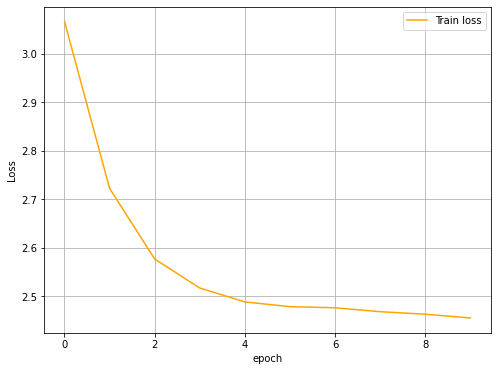

In [17]:
plt.figure(figsize = (8, 6))
plt.plot(all_loss, 'orange', label = 'Train loss')
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

In [18]:
y_pre = net(X_test)
y_pre = y_pre.data.numpy()
mae = mean_absolute_error(y_test, y_pre)
print('Абсолютная ошибка:', mae)

Абсолютная ошибка: 1.1555742


# Вывод

Из всех рассмотренных оптимизаторов SGD показала лучшую сходимость.